In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import casual_tokenize
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras_preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Convolution1D
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling1D
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns; sns.set()
import re
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from ipywidgets import interact

In [108]:
raw_full_train = pd.read_csv("train_copy.csv")
raw_full_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [109]:
# Loading test_data to be able to modify with train data
test_data = pd.read_csv("test_copy.csv")

## High Level Exploration

In [110]:
# DF shape
print("DF Shape:")
print(raw_full_train.shape)

DF Shape:
(159571, 8)


In [111]:
# Checks for nuls
raw_full_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [112]:
label_headers_list = list(raw_full_train.columns[2:])
label_headers_list

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [113]:
# Making sure that I have only 0 and 1 values
for label in label_headers_list:
    print(label, raw_full_train[label].unique())

toxic [0 1]
severe_toxic [0 1]
obscene [0 1]
threat [0 1]
insult [0 1]
identity_hate [0 1]


In [114]:
# Checking the percentage of positive per label
# In the chart - keeping the label order rather than gradually descending
percent_positive_all_labels = [raw_full_train[label].mean() * 100 for label in label_headers_list]
percent_per_label = list(zip(label_headers_list, percent_positive_all_labels))
percent_per_label

[('toxic', 9.584448302009765),
 ('severe_toxic', 0.9995550569965721),
 ('obscene', 5.2948217407925),
 ('threat', 0.2995531769557125),
 ('insult', 4.936360616904074),
 ('identity_hate', 0.8804858025581089)]

Text(0.5,0,'Categoty')

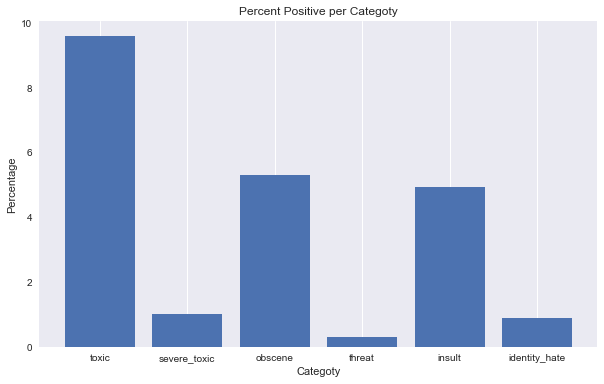

In [115]:
ax = plt.figure(figsize=(10,6)).gca()
ax.bar(x=list(range(6)), height=percent_positive_all_labels, tick_label=[label for label in label_headers_list])
ax.yaxis.grid()
ax.set_title("Percent Positive per Categoty")
ax.set_ylabel('Percentage')
ax.set_xlabel('Categoty')

In [116]:
# Spliting the data
train_data, val_data = train_test_split(raw_full_train, test_size=0.2, random_state=0)

In [117]:
# Making sure that I have the same proportions (roughly) of positives
data_sets = [train_data, val_data]
percent_positive_train_val = []
# The following loop calculates the percentage of the positive values for both the train and val data
for dataset in data_sets:
    percent_positive_per_dataset = [dataset[label].mean() * 100 for label in label_headers_list]
    percent_positive_train_val.append(percent_positive_per_dataset)   

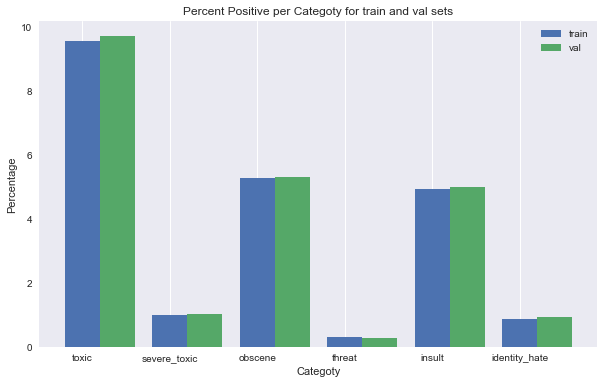

In [118]:
# Plotting
ax = plt.figure(figsize=(10,6)).gca()
width = 0.4
ax.bar(x=np.array(list(range(6)))-width/2, height=percent_positive_train_val[0], width = width, tick_label=label_headers_list,\
      label="train")
ax.bar(x=np.array(list(range(6)))+width/2, height=percent_positive_train_val[1], width = width, label='val')
ax.yaxis.grid() 
ax.set_title("Percent Positive per Categoty for train and val sets")
ax.set_ylabel('Percentage')
ax.set_xlabel('Categoty')
ax.legend()

It's OK

**Comment's length - words**

In [119]:
# Didn't worked in floydhub without this:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ishay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [120]:
# Now I am checking the length of the comments
def count_word(text):
    tokenixed = word_tokenize(text)
    return len(tokenixed)
# Creating a column with the number of words
train_data["n_words"] = train_data["comment_text"].apply(count_word)

C:\Users\ishay\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## ?
Why do I need to use .loc here?

In [121]:
# def count_sent(text):
#     tokenixed = sent_tokenize(text)
#     return len(tokenixed)

# train_data["n_sent"] = train_data["comment_text"].apply(count_sent)

In [122]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,n_words
157279,db5b4c7e09a2e9d4,"""\n\nHmmm, the work of Polish proffesors is no...",0,0,0,0,0,0,20
1259,03624b38905d611f,Why I'm talking to you?,0,0,0,0,0,0,7
1562,043411a0a4d61e95,Dueling unit costs\n\nI've removed the dueling...,0,0,0,0,0,0,79
95532,ff71d44c20144c8d,"""\n\nOkay, let's settle this\nLook above, at t...",0,0,0,0,0,0,166
104452,2ecc07eaf7e735b0,"""\nYou have been asked to explain what is POV ...",0,0,0,0,0,0,22


First I want to examine the optimal length of the comment input (the size of each comment to be used for the model) for padding.

Text(0.5,0,'Nuber of words per comment')

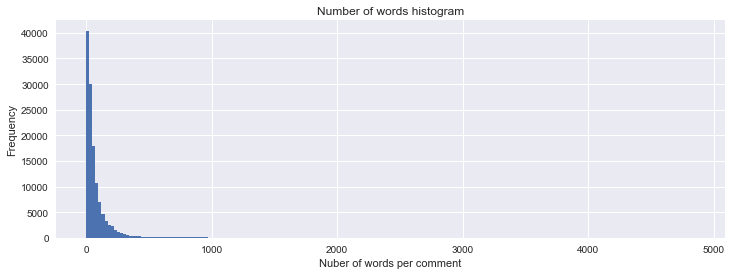

In [123]:
plt.figure(figsize=(12,4))
train_data["n_words"].hist(bins=200)
plt.title("Number of words histogram")
plt.ylabel("Frequency")
plt.xlabel("Nuber of words per comment")

I can see that there are posts (not many) that are very long (up to 5000 words). Or the other hand. The mass of the postsquite short. I need to zoom in.

Text(0.5,0,'Nuber of words per comment')

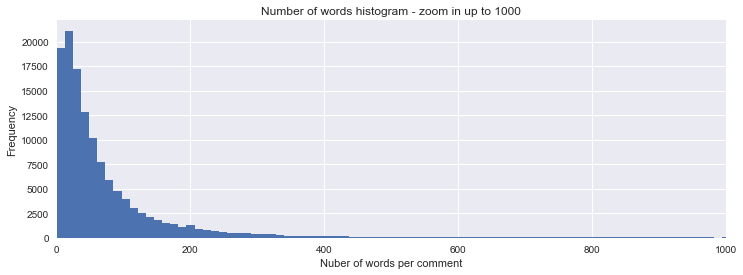

In [124]:
# Now zoom in up to 1000
plt.figure(figsize=(12,4))
train_data["n_words"].hist(bins=400)
plt.xlim(0,1000)
plt.title("Number of words histogram - zoom in up to 1000")
plt.ylabel("Frequency")
plt.xlabel("Nuber of words per comment")

I can use a length of 200 for padding. This cover the majority of hte text.

In [125]:
# Define the number of words per comment
max_len = 200

Text(0.5,0,'Nuber of words per comment')

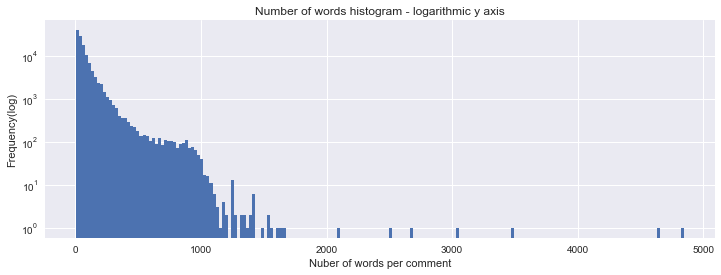

In [126]:
# Checking what is beyond 1000 words by scaling the y axis
plt.figure(figsize=(12,4))
train_data["n_words"].hist(bins=200)
plt.yscale('log', nonposy='clip')
plt.title("Number of words histogram - logarithmic y axis")
plt.ylabel("Frequency(log)")
plt.xlabel("Nuber of words per comment")

In [127]:
# Get a sense of the comments length by the mean and median
print("Median no. of words:", train_data['n_words'].median())
print("Mean no. of words:", train_data['n_words'].mean())

Median no. of words: 43.0
Mean no. of words: 80.3081641285956


Second thing I want to examone if there is a difference in length between a toxic comment (of all kinds) and a non-toxic one.

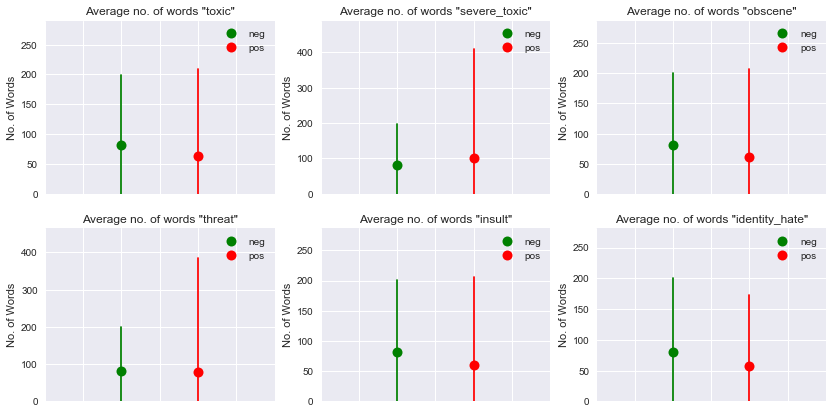

In [23]:
fig = plt.figure(figsize=(14,7))
for label, i in zip(label_headers_list, range(1,7)): 
    # I need to start the range from 1 because the add_subpolt takes values larger than 1
    # Calculating mean and std for only negative and only positive comment for each category (label) 
    mean_negative = train_data['n_words'][train_data[label] == 0].mean()
    std_negative = train_data['n_words'][train_data[label] == 0].std()
    mean_positive = train_data['n_words'][train_data[label] == 1].mean()
    std_positive = train_data['n_words'][train_data[label] == 1].std()
    # plotting
    ax=fig.add_subplot(2,3,i)
    ax.plot(1, mean_negative, "." , ms=20, c='g', label = 'neg')
    ax.plot(2, mean_positive, "." , ms=20, c='r', label = 'pos')
    ax.plot((1,1), (mean_negative-std_negative, mean_negative+std_negative), c='g')
    ax.plot((2,2), (mean_positive-std_positive, mean_positive+std_positive), c='r')
    ax.set_xlim(0,3)
    ax.set_ylim(0,max(mean_negative+std_negative, mean_positive+std_positive)+80)
    ax.set_title('Average no. of words "{}"'.format(label))
    ax.set_xticklabels("")
    ax.set_ylabel("No. of Words")
    ax.legend()

The difference between positive and negative comments is not significant in terms of the no. of words

## **Examining Text**

**General**

The purpose of this section is to see what kind of cleaning / preprocessing I need to do. In addition, I am trying to see what characterizes each category.

In [24]:
print(train_data.iloc[3,1])

"

Okay, let's settle this
Look above, at the section titled ""Peter and the 4th Grade.""  The response to that question is, and I quote, ""No because it is just a joke. Using throwaway comments or jokes as a source of information is specifically mentioned as something to avoid in Manual of Style (writing about fiction).""

The gag about creationists being stupider than retards is only a throwaway gag in the episode Petarded, and is never even spoken orally, only written on a cardboard sign.  Therefore, it doesn't belong here.!  If it were a recurring gag, like that of Ernie the Giant Chicken, then it would belong, but it only makes a cameo appearance in one episode, and therefore is not notable enough to be included anywhere but the cultural references section of the Petarded article."


In [25]:
print(train_data.iloc[7,1])

Is this your Horse?

 and its erect penis]]


In [26]:
print(train_data.iloc[8,1])

HMS Loch Killisport 

I thought Prince Philip was an Officer on the HMS Loch Killisport an the end of 1945 bringing  surviving POW's from Java to Singapore ??? We were on that ship then too.

Can somebody confirm Prince Philip served on HMS Loch Killisport ??

  
GLemmens1940


In [27]:
# Capital letters
print(train_data.iloc[11,1])

YOU FUCKERS THINK YOU CAN STOP ME, YOU REALLY THINK SO. WELL NIGGER FAGS I AM ON THE SIDE OF WIKIPEDIA VANDALS AND I WILL TEL YOU SOMETHING. TONIGHT AT ABOUT 9:30 I WILL VANDALIZE THE THE PAGES OF EVERYONE THAT HAS REVERTED MY VANDALISM OR ADDED THIS TWO WEEK BLOCK TO ME. iF YOU WANT TO FIND OUT WHO THAT WILL BE...JUST CHECK THE 'HISTORY' SECTION OF MY PAGE TO SEE THE NAMES. WHEN I DO VANDALIZE YOU TONIGHT I WILL COMMENT ON HOS I TOLD YOU I WAS GOING TO DO IT. SO IF YOU EDITED MY PAGE TODAY OR IF YOU ARE ONE OF THE PEOPLE THAT DAIS THEY WOULD 'WATCH' MY PAGE TO SEE IF I AM VANDALIZING...THEN GET READY TO HAVE YOUR SHIT CRUSHED YOU NIGGERS. YOU CANT STOP ME. SEE YOU TONIGHT AT 930 NIAGETTY FAGGET CUNTS.


In [28]:
# Various marks
print(train_data.iloc[14,1])

"|decline=When your block is over, you should show your willingness and ability to edit productively.  —  (talk · contribs) }}
Even if you don't like my response, you are not allowed to simply revert it; if you want to request a second review, you may place the request below my response to your first request. - (talk · contribs) "


In [29]:
# Links
print(train_data.iloc[16,1])

"

 Edit request from Drumking, 28 July 2011 

In the section http://en.wikipedia.org/wiki/Israel#Conflicts_and_peace_treaties,
the link to the ""Sabra and shatila camp massacre"" is broken, most likely the name is obsolete.

The link should be to http://en.wikipedia.org/wiki/Sabra_and_Shatila_massacre

  "


In [30]:
# Smilies :)
word_tokenize(train_data.iloc[17,1])

['``',
 'Edit',
 'request',
 'from',
 'Jayjoanz',
 ',',
 '14',
 'February',
 '2011',
 'Please',
 'add',
 'the',
 'following',
 'information',
 'to',
 'the',
 '``',
 "''",
 'Public',
 'Image',
 "''",
 "''",
 'section',
 'of',
 'Lady',
 'Gaga',
 "'s",
 'page',
 ':',
 'Lady',
 'Gaga',
 "'s",
 'public',
 'perception',
 'is',
 'always',
 'amongst',
 'the',
 'most',
 'controversial',
 'of',
 'topics',
 'in',
 'popular',
 'culture',
 '.',
 'Debate',
 'about',
 'her',
 'style',
 'and',
 'influence',
 'on',
 'youth',
 'stems',
 'from',
 'her',
 'unceasing',
 'desire',
 'to',
 'walk',
 'the',
 'thin',
 'line',
 'between',
 'daring',
 'and',
 'inappropriate',
 '.',
 'The',
 'pop',
 'stars',
 'ability',
 'to',
 'command',
 'the',
 'attention',
 'of',
 'her',
 'fans',
 'and',
 'critics',
 'is',
 'unmatched',
 'and',
 'with',
 'a',
 'growing',
 'list',
 'of',
 'hit',
 'records',
 'she',
 'has',
 'solidified',
 'herself',
 'as',
 'a',
 'marketable',
 'brand',
 '.',
 'Her',
 '2.8',
 'million',
 'Twitt

In [31]:
# Many acronyms
print(train_data.iloc[41,1])

Advice requested
Hi E8, I am fairly new here, and would welcome some advice on an issue.  I have been doing some work on supercritical fluid articles, and just noticed a new Super critical carbon dioxide.  There is already a Supercritical carbon dioxide and a supercritical fluid.  this new addition basically takes a chunk of the Supercritical fluid article, and prefaces it with CO2 in carbon capture and storage.  Now whilst CCS is important, this new article fragments the coverage too far, IMO.  I had in mind replacing the Supercritical CO2  with a re-direct to supercritical fluids anyway.  How do I go about raising this for attention?  Thanks for any assistance you can give.


In [32]:
print(train_data.iloc[63,1])

"
Between when I left the request and when you replied here you've made 6 edits to 3 articles, including 3 edits to The Real Housewives of Orange County. It does not matter that the table ""has been there the longest"". If it doesn't comply with our policies and guidelines it needs to be fixed, not left in a non-compliant format. I am clearly not the only one complaining about the table. Numerous editors have attempted to change this and similar tables at various articles and you've reverted them without explanation. That's edit-warring, which can result in you being blocked from editing. There's even a Request for Comment open at WT:TV. However, even if I was the only one complaining, that's irrelevant. It just happens that I noticed the lack of compliance. Removing bolding from the table is simply not enough; the table needs to fully comply, which means incorporating row and column scopes, plainrowheaders, and fixing capitalisation problems as a minimum. There are numerous errors in 

**Examining "toxic" comments**

In [33]:
toxic_data = train_data[train_data["toxic"] == 1]

In [34]:
toxic_data.iloc[0,1]

'Is this your Horse?\n\n and its erect penis]]'

In [35]:
toxic_data.iloc[100,1]

'Destroing his eyes \n\nI will destroy your eyes.'

In [36]:
toxic_data.iloc[101,1]

"I didn't want to vandalise the 1961 F-84 Thunderstreak incident. Have you understood dirty fucking jew.37.99.254.141"

In [37]:
# 'don\'t.... I\'m... doesn\'t
toxic_data.iloc[102,1]

'"Honestly, that was not ""threats of harassment"", maybe it sounds like it... but you don\'t know about the actual situation and what happened in the past. GVnayR is a very ""dangerous"" Wikipedian, I can deepen it. I\'m editing Wikipedia since 2010 and I can say that he is the lamest, weirdest, most ""dangerous"", etc. In my opinion being blocked indefinitely because of this is not fair (1~2 months is more fair). Sadly, blocking this user Hydao (who always fought against vandalism and addition of nonsense things) will not solve the problem. Sooner, the user GVnayR will start adding completely stupid and nonsense things on Wikipedia, which is unacceptable. I will continue fighting against vandalism and nonsense stuff (added by losers/nolifers like GVnayR), with or without ""Hydao"". Now you are thinking: ""Hydao, you are insulting a user by calling ""loser and no-lifer"", but that\'s not an insult, it\'s just the reality. A high-functioning autistic who doesn\'t work, doesn\'t have a 

In [38]:
toxic_data.iloc[103,1]

'( \n\nwtf stop deleting my stuff! you have a first grade education!@$$hole'

In [39]:
toxic_data.iloc[106,1][:300]

'thanks for watching wiki raid threads and ruining fun, dick faggot\nthanks for watching wiki raid threads and ruining fun, dick faggot\nthanks for watching wiki raid threads and ruining fun, dick faggot\nthanks for watching wiki raid threads and ruining fun, dick faggot\nthanks for watching wiki raid th'

**Examinig "severe_toxic" comments**

In [40]:
severe_toxic_data = train_data[train_data["severe_toxic"] == 1]

In [41]:
# ':' and other sibmols separate words
severe_toxic_data.iloc[50,1]

'fuck you bitch. and fuck you lousy and misleading wikipedia:chemtrail page'

In [42]:
severe_toxic_data.iloc[51,1][:200]

'YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER!YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJE'

In [43]:
severe_toxic_data.iloc[52,1][:200]

'"\n\n Fuck you, cunt!!!!!!!!!!!!!!!!!!!!! \n\ntry these important things and maybe you won\'t be such a sucker motherfucker:\n\n1. Learn how to spell. If things remain as they are, everyone is bound to consi'

In [44]:
severe_toxic_data.iloc[53,1]

"Halcy \n\nSeems like you get mad alot. Want me to call the WAAAAAMBULANCE for you? Want some dick (extra small) with that too, bitch? U mad? butthurt? I bet you're having an orgy with MeetTheMedic and MeepTheSheep, aren't you? You three would make a good threesome. You're all reject 4-Chan trolls that became admins on another website to have Unwarranted Self Importance while you spam faggot and dick all day. Seems like you enjoy that kind of stuff. I had no idea, really. \n\nTL;DR: U mad?"

In [45]:
severe_toxic_data.iloc[55,1]

"Hey John, it wasn't a fucking test moron"

In [46]:
severe_toxic_data.iloc[56,1]

'i dont lambs12 \n\nwikipedia sucks ass pussy in the dick i dont give a pussy fuck about lambs12 bitch nigger asshole cock  retyc'

In [47]:
severe_toxic_data.iloc[57,1]

'You are a fucking cunt and I am going to track you down fuck head piece of shit.'

**Examining "obscene" comments**

In [48]:
obscene_toxic_data = train_data[train_data["obscene"] == 1]

In [49]:
obscene_toxic_data.iloc[30,1]

'Jerk\nIll shwo you idiot! I will finish your life you idiot! For the last time! There is NO name to the Cathedral! That is it! Do uyou understand?'

In [50]:
obscene_toxic_data.iloc[31,1]

'FUCK YOU \n\n70.17.2.2 Forever'

In [51]:
# This one is also a severe_toxic and an insult
obscene_toxic_data.iloc[31,:]

id                             1cc84b340259d6c6
comment_text     FUCK YOU \n\n70.17.2.2 Forever
toxic                                         1
severe_toxic                                  1
obscene                                       1
threat                                        0
insult                                        1
identity_hate                                 0
n_words                                       4
Name: 10892, dtype: object

In [52]:
obscene_toxic_data.iloc[32,1]

'Where do you get off deleting that? it took me ages to do and you jus come and delete it, all the while leaving your shitty MTV bollox up, you fucking Americans are nothing but a bunch of fucking hicks. Your presidents a fucking redneck hick and I cant wait to see the day when that bastard gets a nuke up his arse!!!'

In [53]:
obscene_toxic_data.iloc[33,1]

'and suck a dick two times every hour until sunrise'

In [54]:
# This one is also an insult
obscene_toxic_data.iloc[33,:]

id                                                0e7bf095144c3b75
comment_text     and suck a dick two times every hour until sun...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          1
threat                                                           0
insult                                                           1
identity_hate                                                    0
n_words                                                         10
Name: 5431, dtype: object

In [55]:
obscene_toxic_data.iloc[34,1]

'Whoever wrote the comment above, u r my Fuckin HERO!!!!!!!!!!!! WOOOOO! Rock on!'

In [56]:
obscene_toxic_data.iloc[35,1]

'fuck you you dumb motherfucking asshole how dare you son of a bitch fucking lock me out you worthless asshole I hate your guts go to hell you have not seen the last of me I will continue to harass you you piece of shit evryday and screw oregon bitch!'

**Examining "threat" comments**

In [57]:
threat_toxic_data = train_data[train_data["threat"] == 1]

In [58]:
threat_toxic_data.iloc[50,1]

'I like you \n\nI kill you last.'

In [59]:
threat_toxic_data.iloc[51,1]

"Bertie, You're A Stupid Ignorant Cunt !!\n\nDo Humanity a favor and follow in Di's footsteps. Fuck Off and Die.........."

In [60]:
threat_toxic_data.iloc[52,1][:200]

'I am going to kill you. I am going to murder you. I am going to kill you. I am going to murder you. I am going to kill you. I am going to murder you. I am going to kill you. I am going to murder you. '

In [61]:
threat_toxic_data.iloc[53,1]

'SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!'

In [62]:
threat_toxic_data.iloc[54,1]

"Hi, fuckwit. You do know that by blocking me you are violating basic human rights and freedom of expression. And by you deleting my rant is just plain ridicilous. That just proves that all you are is a bunch of fascist douche bags that should've been bombed to death in WWII. Now, please kindly fuck off? thank you."

In [63]:
threat_toxic_data.iloc[55,1]

'FUCK YOU \n\nYOU ARE THE BIGGEST PIG ON THE PLANET.\n\nDIE IN HELL ASSHOLE!'

In [64]:
threat_toxic_data.iloc[56,1]

'AN UGLY CHILD AND I WILL KILL YOU LIKE A CAT IN A BOX.....maybe.'

In [65]:
threat_toxic_data.iloc[57,1]

"You Are A Piece Of Shit \n\nHow dare you deface the truth! You disgusting piece of slime, you vile wretch, you do not deserve life, I should take your pathetic heart out of your chest and watch its' last withering beats die out in my hand. NOOB. SCUM. \n\nWhen I am the supreme ruler of planet earth I will see to it that you are the first to be thrown into the furnace, I will heat the populace of my great cities with your ashes.\n\nD I E\n\nhehe"

**Examining "insult" comments**

In [66]:
insult_toxic_data = train_data[train_data["insult"] == 1]

In [67]:
insult_toxic_data.iloc[100,1][:200]

'FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIECE OF SHIT'

In [68]:
insult_toxic_data.iloc[101,1]

'"\n\n Doug you\'re an nobody. You are some old bored fart who sits on wikipedia even on Christmas day, with 80,000 worthless edits. Its pure psychological projection on your behalf that you regularly attack people as here  ""Author has no degree"" when you have been exposed as a total charlatan as having no degree yourself, despite listing on your user account that you are an ""academic"".   "'

In [69]:
# Pure insult (no severe, no obscene)
insult_toxic_data.iloc[102,1]

'Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker Wanker'

In [70]:
insult_toxic_data.iloc[103,1]

'You are a mother fucking son of a bich you asshole'

In [71]:
insult_toxic_data.iloc[104,1]

'How About You Shut the Fuck Up? \n\nStop fucking with my posts you fucking douche bag\n\nI AM Joe Torres. Leave me be.'

In [72]:
insult_toxic_data.iloc[105,1]

'Your still a dickface dude.'

**Examining "identity_hate" comments**

In [73]:
identity_hate_toxic_data = train_data[train_data["identity_hate"] == 1]

In [74]:
identity_hate_toxic_data.iloc[105,1]

"Go fuck yourself!!! you fucking delteted it anyway! whats the fucking point of a public Encyclopedia if you delete evrything!?!?!? I've edited a few pages so that they are more dettailed and wtf do you all do!?!!?!?!?!?! fucking get rid of it!!!!!!! and dumb down articles just to cater for you publicly ignorant american twats I hope George Bush gets killed by Islams fuck you all!!"

In [75]:
identity_hate_toxic_data.iloc[106,1]

"You fucking piece of shit \n\nI'm going to hunt you down and murder you violently, you disgusting paki twat"

In [76]:
identity_hate_toxic_data.iloc[107,1]

'Hi Motherfucker Zhanzhao, are you a slant-eyed chink or a blackie indian or both? \n\nSays the above. Answer my question, Fucker. 218.186.12.250'

In [77]:
identity_hate_toxic_data.iloc[108,1]

"Fraggle81 \nYou're a faggot."

In [78]:
identity_hate_toxic_data.iloc[109,1]

'Gay \n\nThe existence of CDVF is further proof that  is a sad twat. He is also very ugly, and has a willy for a face.'

**Conclusions**

General:
- The words 'don't', 'won't, etc. are provided as: 'don\'t', 'won\'t'. Need to clean
- Also '\n'. NLTK tokenizer "eats" it. OK. Need to make sure also keras Tokenizer
- Internet links: normally the link is one token (unless broken with '#' for example)
- Many symbols and punctuation: '{', '}', '.', ',', '-' and many others. Need to see when is the proper phase to take them out
- Exclamation (or a few in a row) mark may imply toxicity
- Emogies - saw one

Cosider use **casual_tokenize** (from nltk.tokenize.casual) or **wordpunct_tokenize** or **MWETokenizer**

"toxic" comments:
- If pure "toxic" (no other category in addition), these are soft bad comments, like "grow up", "shut up", "who was the idiot to ..." etc.
- Normally for each of the other category, "toxic" will be positive as well

"severe_toxic" comments:
- Very rusde words, often with sexual connotaitons: "fuck", "bitch", "kocksucker", "dick", "pussy", "asshole" etc.
- Normally the "severe_toxic" coment will be positive in "obscene"/"insult", usually both (of course also "toxic")

"obscene" comments:
- Normally will come with "insult"
- Pure "obscene" indicate using dirty lanuage but without any bad implication, like "my fucking hero!"

"threat" comments:
- Use of words like: "kill", "die", "murder", "death" etc.

"insult" comments:
- Normally comes with "obscene" positive
- Pure identified for examole: "wanker"

"identity_hate" comments:
- Use of identity words: "gay", "faggot", "jew", "islam", "paki" etc.

## Data cleaning and preparation for modeling

Here there are four main steps to take:
1. Text cleaning - including all the sub steps, such as punctuation removal, numbers removal, stopwords removal, stemming, droping 1 character
2. Tokenizing - saparating the text into words/tokens. Some of the tokenizers do some of the cleaning as well. This step may come before the cleaning. I chose to do the cleaning as the first step
3. Building an indexed vocabulary
4. Encoding - turn the words to integers according to the
5. Padding - Bring each comment to the same length by padding zeros to short comments and truncating long ones 

Each step can be done with multiple tools and functions 

In [79]:
# Preparation of the input for clean_text function
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

The following fucntion cleans the text, and is used whether I use the NLTK or the Keras tokenization methods.
The function can be modified to examing performance with different cleaning steps.

In [80]:
def clean_text(df, stop_words, stemmer):
    """
    The functions takes a dataframe, and for each string in ["comment_text"], replaces numbers with "<NUM>", takes out the 
    stopwords, stem the words and take single letter tokens out. Then creates a new column with the new text.
    input:
    - df: a pandas dataframe
    - stop_words: a list of stopwords
    - stemmer: an instance of a stemmer
    The function returns a new dataframe with the new column "new_text" that contains the clean text
    """
    sentences = df["comment_text"].values
    counter = 0
    new_text_list = []
    for sent in tqdm(sentences):
        # Taking out numbers and turning into token
        digits = re.compile(r"\d[\d\.\$]*")
        text = digits.sub("<NUM>", sent)
        # Stemming and taking out stopwords
        text_stemed_without_stopwords = [stemmer.stem(word) for word in text.split() if word not in stop_words]
        # Taking out words/symbols of only one character
        text_no_single_letters = [word for word in text_stemed_without_stopwords if len(word) > 1]
        new_text = ' '.join(text_no_single_letters)
        new_text_list.append(new_text)
    # Generating a new column with the clean text
    df["new_text"] = new_text_list
    
    return df

In [84]:
tqdm.monitor_interval = 0 # Prevent the error: RuntimeError: Set changed size during iteration
# Transforming the datasets
dfs = [train_data, val_data, test_data]
train_data_clean, val_data_clean, test_data_clean = [clean_text(df, stop_words, stemmer) for df in dfs] 

A Jupyter Widget

C:\Users\ishay\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A Jupyter Widget

A Jupyter Widget

In [85]:
train_data_clean.iloc[:10,:]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,n_words,new_text
157279,db5b4c7e09a2e9d4,"""\n\nHmmm, the work of Polish proffesors is no...",0,0,0,0,0,0,20,"hmmm, work polish proffesor """"reliabl source"""" ?!"
1259,03624b38905d611f,Why I'm talking to you?,0,0,0,0,0,0,7,whi i'm talk you?
1562,043411a0a4d61e95,Dueling unit costs\n\nI've removed the dueling...,0,0,0,0,0,0,79,duel unit cost i'v remov duel unit cost figur ...
95532,ff71d44c20144c8d,"""\n\nOkay, let's settle this\nLook above, at t...",0,0,0,0,0,0,166,"okay, let settl look above, section titl """"pet..."
104452,2ecc07eaf7e735b0,"""\nYou have been asked to explain what is POV ...",0,0,0,0,0,0,22,you ask explain pov edit summari correct. talk
144720,116c81247025860b,"Sure, no problem. I obviously do not have any ...",0,0,0,0,0,0,47,"sure, problem. obvious posit dispute, side con..."
27657,493885b693d24a36,"""\nSorry man. I couldn't get an image caption,...",0,0,0,0,0,0,50,"sorri man. get imag caption, infobox """"music a..."
127337,a910f85d885854f1,Is this your Horse?\n\n and its erect penis]],1,0,1,0,0,0,11,is horse? erect penis]]
90540,f23ff55817b35935,HMS Loch Killisport \n\nI thought Prince Phili...,0,0,0,0,0,0,52,hms loch killisport thought princ philip offic...
14024,24fada89cc422e8b,"""\n\n pic for storm \n\nHi Julian, which is th...",0,0,0,0,0,0,23,"pic storm hi julian, best map display a? (talk)"


In [86]:
# Example
print("Before cleaning: ", train_data_clean["comment_text"][104])
print()
print("After cleaning: ", train_data_clean["new_text"][104])

Before cleaning:  What page shoudld there be for important characters that DON'T reoccur?
Void, Black Doom, Mephiles, etc

After cleaning:  what page shoudld import charact don't reoccur? void, black doom, mephiles, etc


**Keras Tokenizer**

Below is a diagram with the steps and on the left are the funcitons used.

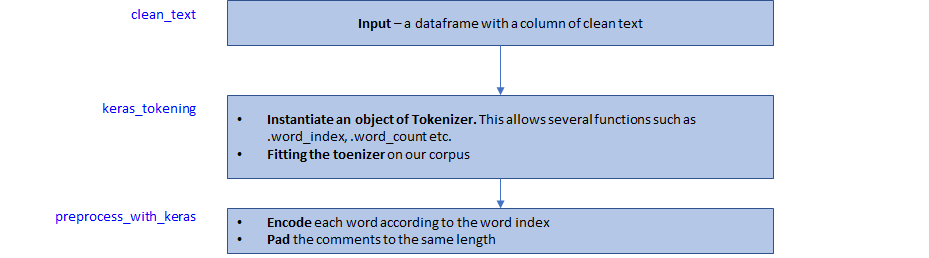

In [87]:
# Define the size of the vocabulary
max_features = 100000

In [88]:
def keras_tokening(df, max_features):
    """Instantiate a Tokenizer object and fit it on a dataframe"""
    # First instantiating
    tokenizer = Tokenizer(num_words=max_features) # Can play with the symbol filter + with lowercase
    # Now I am fitting the tokenizer to the train data 
    tokenizer.fit_on_texts(df["new_text"].values)
    return tokenizer

In [89]:
# Creating the tokenizer and fitting it
tokenizer = keras_tokening(train_data_clean, max_features)

In [90]:
print("word_count: ", len(tokenizer.word_counts))

word_count:  151545


In [91]:
# I define this variable since I will need it later for the model
keras_vocab_size = len(tokenizer.word_index)

In [128]:
#Examining the word_index of the Tokenizer
'that' in tokenizer.word_index

True

tokenizer.word_index.items() gives a warning. To overcome I need to open jupyter with:

jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

## ?
??? I saw in Kaggle that all of the people fit on both train and test. This will give them a better Kaggle score, but it is a bad model, since it will perform poorly on new data (not fitted)????

In [93]:
def preprocess_with_keras(df, max_len, encoding_support=tokenizer):
    """
    The function turns a text into padded arrays, ready as an input for the model
    input:
    - df: a pandas dataframe
    - max_len: the length of the array for padding the comments
    - encoding_support: needs to receive 'tokenozer'. The purpose of this argument is to allow using this function when creating
      the datasets for the model.
    The function return a matrix with the padded arrays
    """
    
    X_text = df["new_text"].values
    X_int = tokenizer.texts_to_sequences(X_text) # Returns a list
    X_pad = sequence.pad_sequences(X_int, maxlen=max_len)
    
    return X_pad

In [129]:
tokenizer.texts_to_sequences(train_data_clean["new_text"].values)

[[4460, 50, 1496, 39352, 239, 339],
 [197, 25, 8, 5],
 [10331,
  442,
  1913,
  92,
  47,
  10331,
  442,
  1913,
  683,
  256,
  969,
  683,
  10,
  1125,
  418,
  1913,
  171,
  503,
  33,
  1850,
  39353,
  59,
  55,
  11,
  1294,
  211,
  1492,
  792,
  1913,
  29192,
  418,
  1913,
  103,
  71526,
  1913,
  13370,
  1913,
  987,
  11742,
  1913,
  14,
  17],
 [784,
  132,
  2263,
  43,
  590,
  64,
  352,
  1845,
  1,
  302,
  2507,
  4,
  456,
  82,
  62,
  2049,
  118,
  1072,
  10,
  13371,
  60,
  1072,
  33,
  73,
  320,
  141,
  151,
  589,
  753,
  228,
  154,
  1513,
  4,
  8931,
  4717,
  583,
  1606,
  13371,
  8931,
  989,
  71527,
  158,
  46,
  2426,
  49381,
  312,
  23832,
  338,
  1568,
  751,
  52,
  15,
  6939,
  8931,
  11,
  11132,
  3636,
  1617,
  13,
  751,
  20,
  10841,
  210,
  12,
  3422,
  682,
  258,
  269,
  103,
  1793,
  769,
  69,
  64,
  49382,
  31],
 [5, 85, 201, 298, 9, 559, 211, 8],
 [136,
  147,
  321,
  532,
  1791,
  496,
  166,
  1230,
  3

## ?
Not sure what value the 'text_to_sequences' assigns to unfamiliar word in val_data/test/data

In [94]:
type(tokenizer.texts_to_sequences(test_data["new_text"].values))

list

**NLTK tokenizing and cleaning**

Below is a diagram with the steps and on the left are the funcitons used.

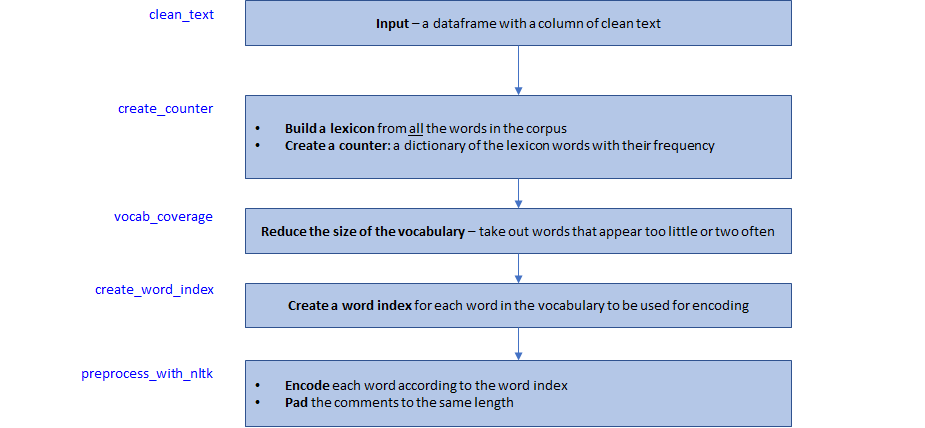

In [95]:
# !!! Currently takes as input only the train_data for the vocabulary!!!
def create_counter(clean_df):
    """
    The purpose of this function is to crate a word counter for a corpus for 1. adjust the desired vocabulary size (see 
    vocab_coverage function), 2. to create a word index for padding (see create_word_index function)
    input:
    - clean_df: a pandas dataframe with a column of clean text (after initial preprocessing)
    The function returns:
    - lexicon: a list of all the tokens in the corpus
    - word_count: a dictionary with all the tokens and their frequency
    """
    
    # First create the full lexicon (all the words/symbols form the new_text colomn)
    lexicon = []
    for sent in tqdm(clean_df["new_text"].values):
        token = casual_tokenize(sent) # Tokenizes each sentence
        lexicon += token # and adds it to the lexicon
    print("Full lexicon length: {}.".format(len(lexicon)))
    # Create a Counter object, which is a dictionary of all the words in the lexicon, and their frequency
    word_counts = Counter(lexicon) 
    print("Counter (unique words) length: {}.".format(len(word_counts)))
    # I need to return both the lexicon and the word_count, since I use then for reducing the vocabulary
    return lexicon, word_counts

In [96]:
# Creating the lexicon and the counter
lexicon, word_counter = create_counter(train_data_clean)

A Jupyter Widget


Full lexicon length: 6510504.
Counter (unique words) length: 171050.


In [98]:
@interact(lb = (1,30), ub =(5000,500000))
def vocab_coverage(lb=1,ub=10000):
    """ The Function allows adjusting the vocabulary size"""
    
    lex_2 = [w for w in word_counter if ub >= word_counter[w] >= lb]
    words_covered = sum([word_counter[word] for word in lex_2])
    corpus_percentage = words_covered/len(lexicon)
    return "Corpus Coverage: {:.2f}%, lexicon used: {} words.".format(corpus_percentage*100, len(lex_2))

A Jupyter Widget

In [99]:
def create_word_index(lb, ub, counter):
    """
    The function creates a word index, where each token is designated with an index. This is used for encoding.
    input:
    - lb: lower bound, the minimum number that a word appears in the original korpus
    - ub: upper bound, the maximum number that a word appears in the original korpus
    - counter: a Counter object that contains the frequency of each word 
    The function returns a dictionary with the words as keys and the index as values 
    """
    
    lexicon_2 = [w for w in counter if ub >= counter[w] >= lb]
    print("New lexicon length: {}.".format(len(lexicon_2)))
    word_index = {}
    counter = 1
    for word in lexicon_2:
        word_index[word] = counter
        counter += 1
    return word_index

In [100]:
word_index = create_word_index(3, 50000, word_counter)

New lexicon length: 50369.


In [101]:
# I define this variable since I will need it later for the model
nltk_vocab_size = len(word_index)

In [102]:
def preprocess_with_nltk(df, max_len, encoding_suppot=word_index):
    """
    The function turns a text into padded arrays, ready as an input for the model
    input:
    - df: a pandas dataframe
    - max_len: the length of the array for padding the comments
    - encoding_support: needs to receive 'word_index'. The purpose of this argument is to allow using this function when creating
      the datasets for the model.
    The function return a matrix with the padded arrays
    """
        
    X_text = df["new_text"].values
    X_encode_list = []
    for sent in tqdm(X_text):
        tokenized = casual_tokenize(sent)
        encoded = np.array([word_index[word] for word in tokenized if word in word_index])
        X_encode_list.append(encoded)
    X_pad = sequence.pad_sequences(X_encode_list, maxlen=max_len)
        
    return X_pad

In [103]:
# The following line allows choosing whether to use the Keras or the NLTK preprocessing 
preprocess_type = 'nltk' # 'keras'/'nltk'

In [104]:
# The following if statement defines whether the preprocessing fuction of Keras or NLTK's will be used according to
# 'preprocess_type' variable
if preprocess_type == 'nltk':
    preprocess_func = preprocess_with_nltk
    support = word_index
    vocab_size = nltk_vocab_size
elif preprocess_type == 'keras':
    preprocess_func = preprocess_with_keras
    support = tokenizer
    vocab_size = keras_vocab_size
else:
    print("Unknown preprocessing function")

In [105]:
    
dfs = [train_data_clean, val_data_clean, test_data_clean]    
X_train_for_model, X_val_for_model, X_test_for_model = [ c(df, max_len, support) for df in tqdm(dfs)]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [137]:
X_test_for_model[27]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

**Embedding Matrix** - TBD

## Modeling

Preparing y sets

In [198]:
y_train = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_val = val_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

Defining the model

In [202]:
def create_model(vocab, length):
    inputs_shape = Input(shape=(length,))
    embed = Embedding(input_dim=vocab, output_dim=200)(inputs_shape)
    spat_drop = SpatialDropout1D(0.2)(embed)
    conv = Conv1D(filters=350, kernel_size=3, padding='valid', activation='relu', strides=1)(spat_drop)
    pool = GlobalMaxPooling1D()(conv)
    dense1 = Dense(250, activation='relu')(pool)
    drop1 = Dropout(0.3)(dense1)
    dense2 = Dense(20, activation='relu')(drop1)
    drop2 = Dropout(0.3)(dense2)
    output = Dense(6, activation='sigmoid')(drop2)
    model = Model(inputs=inputs_shape, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [203]:
model = create_model(vocab_size, max_len)

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 200)          10073800  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 200)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 350)          210350    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 350)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               87750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
__________

In [211]:
epochs = 4
batch_size = 512
h = model.fit(X_train_for_model, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_for_model, y_val),
              verbose=2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/4
  8192/127656 [>.............................] - ETA: 9:47 - loss: 0.1611 - acc: 0.950 - ETA: 9:46 - loss: 0.1547 - acc: 0.953 - ETA: 9:37 - loss: 0.1497 - acc: 0.953 - ETA: 9:32 - loss: 0.1535 - acc: 0.952 - ETA: 9:33 - loss: 0.1547 - acc: 0.952 - ETA: 9:32 - loss: 0.1539 - acc: 0.952 - ETA: 9:32 - loss: 0.1524 - acc: 0.953 - ETA: 9:30 - loss: 0.1496 - acc: 0.953 - ETA: 9:30 - loss: 0.1483 - acc: 0.953 - ETA: 9:30 - loss: 0.1478 - acc: 0.953 - ETA: 9:30 - loss: 0.1494 - acc: 0.952 - ETA: 9:30 - loss: 0.1482 - acc: 0.952 - ETA: 9:29 - loss: 0.1474 - acc: 0.953 - ETA: 9:29 - loss: 0.1464 - acc: 0.953 - ETA: 9:28 - loss: 0.1461 - acc: 0.953 - ETA: 9:28 - loss: 0.1463 - acc: 0.9533

InvalidArgumentError: indices[355,148] = 50369 is not in [0, 50369)
	 [[Node: embedding_2/embedding_lookup = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@training/Adam/Assign_2"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_2/embeddings/read, embedding_2/Cast, training/Adam/gradients/embedding_2/embedding_lookup_grad/concat/axis)]]

In [ ]:
y_pred = model.predict(x_test, batch_size=1024)

In [ ]:
#auc